In [1]:
import sys
sys.path.append('./../')
from src import proyecto_1
from src.pipelines import modeling
from src.utils import utils

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:
proyecto_1.main()

./../src/pipelines/feature_engineering.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)
/Users/yedam/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yedam/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [3]:
modeling.modeling('output/fe_df.pkl')

/Users/yedam/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/yedam/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [4]:
c5_evaluation = utils.load_df('output/model_loop.pkl')

In [6]:
c5_train = utils.load_df('output/fe_df.pkl')
c5_test = utils.load_df('output/test.pkl')

In [8]:
c5_test_ = c5_test.copy()
c5_train_ = c5_train.copy()
c5_train_ = c5_train_.drop('label',axis=1)
names=np.array(c5_test_.dia_semana.unique())
names=np.append(names,np.array(c5_test_.delegacion_inicio.unique()))
names=np.append(names,np.array(c5_test_.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_test_.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))   
#Definicion de transformers
transformers = [('one_hot', OneHotEncoder(), [ 'dia_semana','delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
    ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
    ('mes', SimpleImputer(strategy="mean"), ['mes']),
    ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
    ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
col_trans.fit(c5_test_)
df_input_vars = col_trans.transform(c5_test_)
X = df_input_vars
y = c5_test.label.values.reshape(df_input_vars.shape[0],)

In [33]:
X_test = pd.DataFrame.sparse.from_spmatrix(X)
X_test.columns = names
X_test
selection_test = list(c5_train_.columns)
selection_test
X_test_ = X_test[selection_test]
prediction = c5_evaluation[1].predict(X_test_)
proba = c5_evaluation[1].predict_proba(X_test_)

## ROC

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

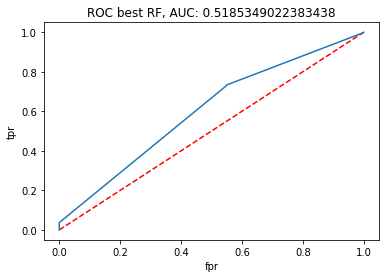

In [40]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y, proba[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y, prediction)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusion

In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, prediction)

array([[219993,      0],
       [ 54420,   2095]])

## Accuracy

In [38]:

from sklearn.metrics import accuracy_score

accuracy_score(y, prediction)

0.8031883345147337

In [41]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y, proba[:,1], pos_label=1)

In [42]:
thresholds_2 = np.append(thresholds_2, 1)

In [43]:
(precision.shape, recall.shape, thresholds_2.shape)

((8,), (8,), (8,))

### Reporte de metricas

In [44]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [45]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.090895,0.204388,1.000000,0.339406,1.000000,1.000000,0.000000,0.000000
1,0.136024,0.204174,0.997859,0.338987,0.997859,0.999177,0.000823,0.002141
2,0.251070,0.255165,0.733168,0.378575,0.733168,0.549790,0.450210,0.266832
3,0.409806,0.255195,0.732531,0.378522,0.732531,0.549227,0.450773,0.267469
4,0.419678,0.254513,0.727648,0.377120,0.727648,0.547527,0.452473,0.272352
5,0.885040,1.000000,0.037070,0.071490,0.037070,0.000000,1.000000,0.962930
6,0.894803,1.000000,0.036769,0.070930,0.036769,0.000000,1.000000,0.963231
